In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lib import make_schedule
from lib_ddrm_fast import DDRM_fast
from lib_svd import Deblurring, SuperResolution
from datasets import get_dataset, data_transform, inverse_data_transform
import torchvision
from torchvision.transforms import ToTensor, Compose, PILToTensor, Normalize, Resize
import os
from PIL import Image
from guided_diffusion.script_util import create_model, create_classifier, classifier_defaults, args_to_dict
from ckpt_util import download
from collections import namedtuple
import argparse
import random

def dict2namespace(config):
    namespace = argparse.Namespace()
    for key, value in config.items():
        if isinstance(value, dict):
            new_value = dict2namespace(value)
        else:
            new_value = value
        setattr(namespace, key, new_value)
    return namespace


In [2]:
# Imagenet 256x256 config, model and schedule
config_dict = dict(
                data = dict(
                        dataset = "ImageNet",
                        image_size = 256,
                        channels = 3,
                        logit_transform = False,
                        uniform_dequantization = False,
                        gaussian_dequantization = False,
                        random_flip = True,
                        rescaled = True,
                        num_workers = 32,
                        subset_1k = True,
                        out_of_dist = False,
                        ),

                model = dict(
                        type = "openai",
                        in_channels = 3,
                        out_channels = 3,
                        num_channels = 256,
                        num_heads = 4,
                        num_res_blocks = 2,
                        attention_resolutions = "32,16,8",
                        dropout = 0.0,
                        resamp_with_conv = True,
                        learn_sigma = True,
                        use_scale_shift_norm = True,
                        use_fp16 = True,
                        resblock_updown = True,
                        num_heads_upsample = -1,
                        var_type = 'fixedsmall',
                        num_head_channels = 64,
                        image_size = 256,
                        class_cond = False,
                        use_new_attention_order = False,
                        ),

                diffusion = dict(
                        beta_schedule = 'linear',
                        beta_start = 0.0001,
                        beta_end = 0.02,
                        num_diffusion_timesteps = 1000,
                        ),

                sampling = dict(
                        batch_size = 8,
                        last_only = True,
                        )

                )

args_dict = dict(

                exp = "./ckpts_ddrm/",
                seed = 1234,
                sigma_y = 0.,
                task = 'deblur',
                eta = 0.85,
                eta_b = 1.0,

                )

config = dict2namespace(config_dict)
args = dict2namespace(args_dict)

if not os.path.exists(args.exp):
        os.mkdir(args.exp)

model = create_model(**config_dict['model'])
if config_dict['model']['use_fp16']:
                model.convert_to_fp16()
                if config_dict['model']['class_cond']:
                    ckpt = os.path.join(args.exp, 'logs/imagenet/%dx%d_diffusion.pt' % (config_dict['model']["image_size"], config_dict['model']["image_size"]))
                    if not os.path.exists(ckpt):
                        download('https://openaipublic.blob.core.windows.net/diffusion/jul-2021/%dx%d_diffusion_uncond.pt' % (config_dict['model']["image_size"], config_dict['model']["image_size"]), ckpt)
                else:
                    ckpt = os.path.join(args.exp, "logs/imagenet/256x256_diffusion_uncond.pt")
                    if not os.path.exists(ckpt):
                        download('https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt', ckpt)
                    
            
                model.load_state_dict(torch.load(ckpt, map_location=torch.device("cuda")))
                model.to(torch.device("cuda"))
                model.eval()
                model = torch.nn.DataParallel(model)


# diffusion schedule
T = 1000
schedule = make_schedule(scheme=config_dict['diffusion']['beta_schedule'], rvar='beta', T=config_dict['diffusion']['num_diffusion_timesteps'], 
                         start_beta=config_dict['diffusion']['beta_start'], end_beta=config_dict['diffusion']['beta_end'])

In [3]:
# DDRM_fast wrapper
ddrm_model = DDRM_fast(schedule=schedule,model=model,weightedloss=False,cuda=True)

In [4]:
# Load imagenet vak 1k subset
#get original images and corrupted y_0
dataset, test_dataset = get_dataset(args, config)
device_count = torch.cuda.device_count()
device = torch.device("cuda")
args.subset_start = 0
args.subset_end = len(test_dataset)
print(f'Dataset has size {len(test_dataset)}')    

def seed_worker(worker_id):
    worker_seed = args.seed % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(args.seed)
val_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=config.sampling.batch_size,
    shuffle=True,
    num_workers=config.data.num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

args.sigma_y = 2 * args.sigma_y #to account for scaling to [-1,1]
sigma_y = args.sigma_y

if args.task == 'deblur':
    H = Deblurring(torch.Tensor([1/9] * 9).to(device), config.data.channels, config.data.image_size, device)        
elif args.task == 'sr4x':
    H = SuperResolution(config.data.channels, config.data.image_size, ratio=4, device=device)
else:
    raise NotImplementedError


building dataset from ./ckpts_ddrm/imagenet_val_1k.txt
read meta done
Dataset has size 1000


/opt/conda/lib/python3.9/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 32 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


For no noise sr4x:
Total Average PSNR: 26.58
Number of samples: 1000

For noisy sr4x: sigma_y = 0.05
Total Average PSNR: 25.22
Number of samples: 1000

For no noise deblur:
Total Average PSNR: 38.71
Number of samples: 1000

For noisy deblur: sigma_y = 0.05
Total Average PSNR: 25.47
Number of samples: 1000

In [ ]:
print(f'Start from {args.subset_start}')
idx_init = args.subset_start
idx_so_far = args.subset_start
avg_psnr = 0.0
#pbar = tqdm.tqdm(val_loader)
pbar  = val_loader
for x_orig, classes in pbar:
    x_orig = x_orig.to(device)
    x_orig = data_transform(config, x_orig)

    y = H.H(x_orig)
    y = y + sigma_y * torch.randn_like(y)
    #print(f"y.shape = {y.shape}, isanynan = {torch.any(torch.isnan(y))}, minmax = {torch.min(y),torch.max(y)}")
    #pinv_y_0 = H_funcs.H_pinv(y_0).view(y_0.shape[0], config.data.channels, self.config.data.image_size, self.config.data.image_size)
    
    #print(f"y.shape={y.shape}")
    ##Begin DDIM
    x = torch.randn(
        y.shape[0],
        config.data.channels,
        config.data.image_size,
        config.data.image_size,
        device=device,
    )
    #print(f"dummyx.shape = {x.shape}, isanynan = {torch.any(torch.isnan(x))}")
    #assert y.shape[0] == config.sampling.batch_size

    with torch.no_grad():
        x = ddrm_model.reverse_diffusion_ddrm(x, y, sigma_y, args.eta, args.eta_b, config.data.channels, config.data.image_size, H=H, T_ddrm=20, cuda=True, onlymean=False)
    
    # NOTE: This means that we are producing each predicted x0, not x_{t-1} at timestep t.
    #with torch.no_grad():
    #    x, _ = self.sample_image(x, model, H_funcs, y_0, sigma_0, last=False, cls_fn=cls_fn, classes=classes)

    #x = [inverse_data_transform(config, y) for y in x]

    x = inverse_data_transform(config, x)
    #print(f"finalx.shape = {x.shape}, isanynan = {torch.any(torch.isnan(x))}")
    #for i in [-1]: #range(len(x)):
    for j in range(x.size(0)):
            #tvu.save_image(
            #    x[i][j], os.path.join(self.args.image_folder, f"{idx_so_far + j}_{i}.png")
            #)
            orig = inverse_data_transform(config, x_orig[j])
            mse = torch.mean((x[j].to(device) - orig.reshape(-1)) ** 2)
            #print(f"mse = {mse}")
            psnr = 10 * torch.log10(1 / mse)
            avg_psnr += psnr

    idx_so_far += y.shape[0]

    #pbar.set_description("PSNR: %.2f" % (avg_psnr / (idx_so_far - idx_init)))
    print("PSNR: %.2f" % (avg_psnr / (idx_so_far - idx_init)))
    #break

avg_psnr = avg_psnr / (idx_so_far - idx_init)
print("Total Average PSNR: %.2f" % avg_psnr)
print("Number of samples: %d" % (idx_so_far - idx_init))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


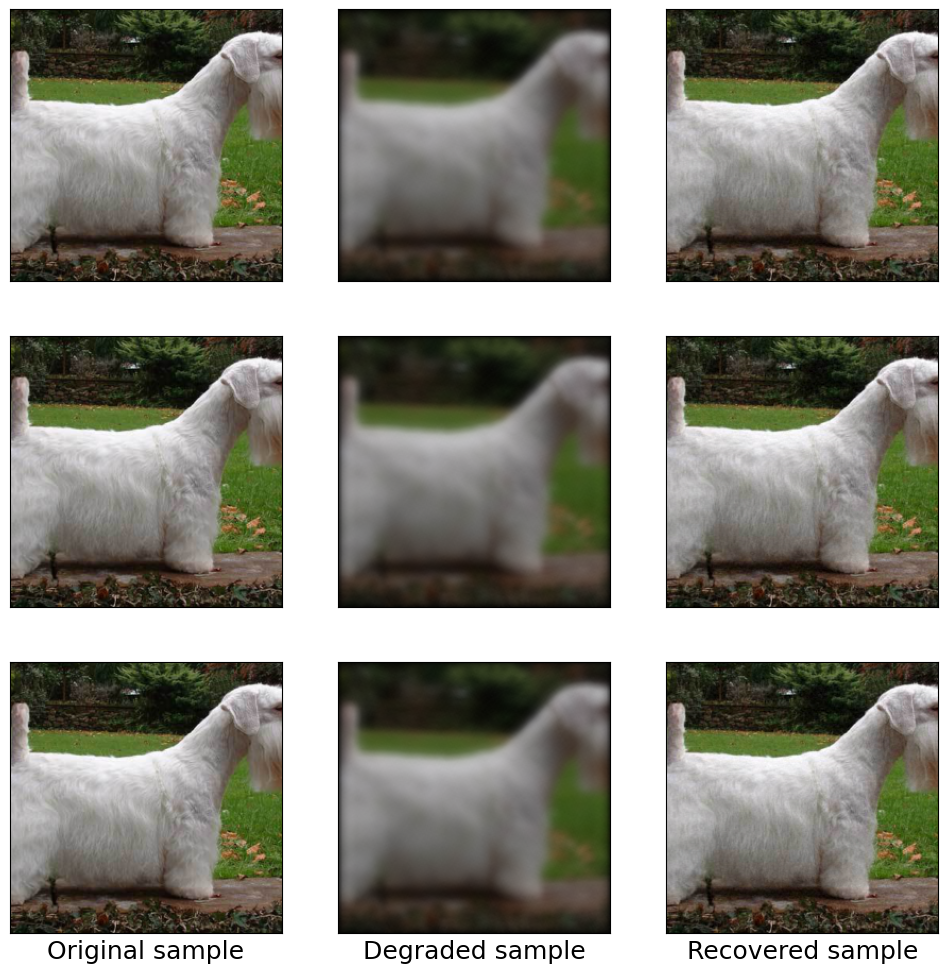

In [ ]:
#visualize_degradation (numsamples, H, dataset, sigma_y=0.0, eta=1.0, eta_b=1.0, T_ddrm=20, seed=42, onlymean=False, channels=0, image_size=0):

numsamples = 3
device = torch.device("cuda")
numcols = 3
f, ax = plt.subplots(ncols=numcols, nrows=numsamples, figsize=(4*numcols,4*numsamples))
np.random.seed(seed=111)
samples = np.random.choice(np.arange(len(test_dataset)),size=None,replace=False)

samples = [samples]*numsamples

for idx,sample in enumerate(samples):
    image, label = test_dataset[sample]
    image = np.array(image, dtype=np.float32)    
    vizimage = np.transpose(image, (1, 2, 0))

    ax[idx, 0].imshow(vizimage,vmin=0.,vmax=1.)    
    ax[idx, 0].set_xticks([])
    ax[idx, 0].set_yticks([])

    #orig_shape = image.shape
    y = H.H(torch.tensor(image, device=device).reshape((1,config.data.channels,config.data.image_size,config.data.image_size)))
    y = y + (sigma_y/2) * torch.randn_like(y)
    s = int(np.sqrt(y.shape[1]//config.data.channels))
    image_degraded = y.reshape((config.data.channels, s, s)).cpu().numpy()
    image_degraded = np.transpose(image_degraded, (1, 2, 0))
    
    ax[idx, 1].imshow(image_degraded,vmin=0.,vmax=1.)    
    ax[idx, 1].set_xticks([])
    ax[idx, 1].set_yticks([])

    
    image = (image - .5) / (.5)
    y = H.H(torch.tensor(image, device=device).reshape((1,config.data.channels,config.data.image_size,config.data.image_size)))
    y = y + sigma_y * torch.randn_like(y)
    dx = torch.randn(
        y.shape[0],
        config.data.channels,
        config.data.image_size,
        config.data.image_size,
        device=device,
    )
    recovered_image = ddrm_model.reverse_diffusion_ddrm(dx, y, sigma_y, args.eta, args.eta_b, config.data.channels, config.data.image_size, H=H, T_ddrm=20, cuda=True, onlymean=False)
    recovered_image = recovered_image.cpu().numpy()
    recovered_image = np.transpose(recovered_image.reshape((config.data.channels, config.data.image_size, config.data.image_size)),(1,2,0))
    
    ax[idx, 2].imshow(.5*(recovered_image + 1.),vmin=0.,vmax=1.)    
    ax[idx, 2].set_xticks([])
    ax[idx, 2].set_yticks([])
    
    if idx == len(samples)-1:
        ax[idx, 0].set_xlabel('Original sample', fontsize=6*numcols)
        ax[idx, 1].set_xlabel('Degraded sample', fontsize=6*numcols)
        ax[idx, 2].set_xlabel('Recovered sample', fontsize=6*numcols)

